# Poisson Kriging - centroid based approach - tutorial

## Table of Contents:

1. Load areal and point data,
2. Load semivariogram (regularized),
3. Remove 10% of areal dataset,
4. Predict values at unknown locations,
5. Analyse Forecast Bias and Root Mean Squared Error of prediction.

## Level: Advanced

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2021-05-28 | Updated paths for input/output data | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data. | @SimonMolinsky |

## Introduction

To start this tutorial it is required to understand concepts in the **Ordinary and Simple Kriging** and **Semivariogram Regularization** tutorials.

Poisson Kriging technique is used to model spatial count data. We are analyzing special case where data is counted over areas. Those areas may have irregular shapes and sizes beacuse they represent administrative regions. 

In this tutorial we try to predict rates of Breast Cancer in Pennsylvania counties. Along with areal data we use U.S. Census 2010 data for population blocks.

> Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/cancer_data.shp`.

> Population blocks data is stored in the shapefile in folder `sample_data/population_data/cancer_population_base.shp`

Even if our areal data has units with irregular shapes and sizes but for the case of this tutorial we assume that each region may be represented by its centroid. This is huge simplification but in some cases it could be taken into account. 

Centroid-based Poisson Kriging is much faster than Area-to-Area or Area-to-Point Poisson Kriging and for some applications it may be desired property.

This tutorial covers following steps:

1. Read and explore data,
2. Load semivariogram model,
3. Prepare training and test data,
4. Predict values of unknown locations and calculate forecast bias and root mean squared error,
5. Analyse error metrics.

## 1) Read and explore data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate.io_ops import prepare_areal_shapefile, get_points_within_area
from pyinterpolate.semivariance import TheoreticalSemivariogram
from pyinterpolate.kriging import CentroidPoissonKriging

In [2]:
areal_data_file = '../sample_data/areal_data/cancer_data.shp'
point_data_file = '../sample_data/population_data/cancer_population_base.shp'

areal_id_column_name = 'FIPS'
areal_val_column_name = 'rate'
points_val_column_name = 'POP10'


areal_data = prepare_areal_shapefile(areal_data_file,
                                     id_column_name=areal_id_column_name,
                                     value_column_name=areal_val_column_name)
point_data = get_points_within_area(areal_data_file, point_data_file, areal_id_col_name=areal_id_column_name,
                                   points_val_col_name=points_val_column_name)

/Users/szymonmolinski/miniconda3/envs/pyint/lib/python3.7/site-packages/pyinterpolate/io_ops/get_points_within_area.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(output_points_within_area)


<AxesSubplot:>

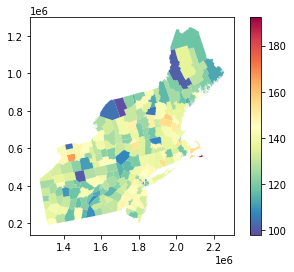

In [3]:
# Lets take a look into a map of areal counts

gdf = gpd.read_file(areal_data_file)
gdf.plot(column='rate', cmap='Spectral_r', legend=True)

#### Clarification: 

It is good idea to look into the spatial patterns in dataset and to visually check if our data do not have any NaN values. We use geopandas GeoDataFrame plot function for it with color map which is diverging color classes well.

## 2) Load semivariogram model

In this step we load regularized semivariogram from the tutorial **Semivariogram Regularization (Intermediate)**. You can always perform semivariogram regulariztion along with the Poisson Kriging but it is a very long process and it is more convenient to separate those two steps.

In [4]:
semivariogram = TheoreticalSemivariogram()  # Create TheoreticalSemivariogram object
semivariogram.import_model('output/regularized_model.csv')  # Load regularized semivariogram

## 3) Prepare training and test data

We simply remove 10% of random ID's from areal dataset (the same for points) and create four arrays: two training arrays with areal and point geometry and values and two test arrays with the same categories of data.

In [5]:
# Remove 10% of rows (values) to test our model

def create_test_areal_set(areal_dataset, points_dataset, frac=0.1):
    """
    Function creates set with random areas for tests
    
    INPUT:
    :param areal_dataset: (numpy array) array with rows of areal records,
    :param points_dataset: (numpy array) array with rows of points records,
    :param frac: (float) number of elements in a test set
    
    OUTPUT:
    return: [training_set_areal(numpy array),
             test_set_areal (numpy array),
             training_set_points (numpy array),
             test_set_points (numpy array)]
    """
    
    all_ids = areal_dataset[:, 0]
    training_set_size = int(len(all_ids) * (1 - frac))
    training_ids = np.random.choice(all_ids,
                                    size=training_set_size,
                                    replace=False)
    training_areas = np.array(
            [a for a in areal_dataset if a[0] in training_ids])
    test_areas = np.array(
            [a for a in areal_dataset if a[0] not in training_ids])
    training_points = np.array(
            [pt for pt in points_dataset if pt[0] in training_ids])
    test_points = np.array(
            [pt for pt in points_dataset if pt[0] not in training_ids])
    

    output = [training_areas, test_areas, training_points, test_points]
    return output

ar_train, ar_test, pt_train, pt_test = create_test_areal_set(areal_data, point_data)

## 4) Predict values at unknown locations and calculate forecast bias and root mean squared error

Do you know scikit-learn's fit-predict-transform estimation procedure? With Kriging it is more complicated because we are fitting semivariogram model to data and we pass this fitted model into kriging estimator. That's why package with *TheoreticalSemivariogram()* class is named **fit_semivariance**.
You may start work with predictions with fitted semivariogram model. Centroid-based Poisson Kriging takes three arguments during initialization:

=> semivariogram model (fitted semivariogram model),

=> known areas (training set),

=> known points (training set).

After initilization you may perform prediction. This process requires you to control three hyperparameters:

=> **number of observations** (the most important parameter - how many neighbors are affecting your area of analysis),

=> minimum **search radius** (minimum search radius for analysis from your area of interest, if there are less areas than number of observations then the new, next closest neighbors are included in the analysis),

=> **weighted** by population? (bool parameter, if True then distances are weighted by population between points - default is True for Poisson Kriging).

Why **radius** parameter is less important than **number of observations**? It is a tradeoff between mathemtical accuracy and reality. Usually your areas of interest have different shapes and sizes and with very large county and small search radius from the centroid you may not find any neighbour!

Algorithm in the cell below iteratively picks one area from the test set and perform prediction. Then forecast bias which is difference between real and predicted value is calculated. Forecast Bias is useful to understand if our algorithm predictions are too low or too high (under- or overestimation). The next parameter is Root Mean Squared Error. This kind of measure tells us more about outliers and very large differences between predictions and real values. We will see it in the last part of tutorial.

Your work with Poisson Kriging (or Kriging) will be usually the same:
- prepare training and test data,
- use training data to prepare semivariogram model,
- test different hyperparameters with a test set to find optimal number of neighbors which are affecting your area of analysis,
- forecast into unknown areas OR perform data smoothing.

In [6]:
number_of_obs = 8
radius = 60000  # 60 km

kriging_model = CentroidPoissonKriging(semivariogram_model=semivariogram,
                                       known_areas=ar_train,
                                       known_areas_points=pt_train)
c_predictions = []
for unknown_area in ar_test:
    unknown_points = pt_test[pt_test[:, 0] == unknown_area[0]][0]

    # Predict
    try:
        predicted = kriging_model.predict(unknown_area,
                                          unknown_points,
                                          number_of_obs,
                                          radius,
                                          True)
        predicted_rates = int(predicted[0])
        fb = (unknown_area[-1] - predicted_rates)
        rmse = np.sqrt((fb)**2)
        
        c_predictions.append([unknown_area[0], predicted_rates, unknown_area[-1], fb, rmse])
    except ValueError:
        fb = np.nan
        rmse = np.nan
        c_predictions.append([unknown_area[0], np.nan, unknown_area[-1], fb, rmse])  # All NaN's

In [7]:
c_predictions = np.array(c_predictions)
pred_df = pd.DataFrame(data=c_predictions[:, 1:],
                       index=c_predictions[:, 0],
                       columns=['predicted', 'real', 'forecast bias', 'rmse'])  # Store results in DataFrame

## 5) Analyze Forecast Bias and Root Mean Squared Error of prediction

The last step is analysis of errors. We plot two histograms: of forecast bias and of root mean squared error then we calculate base statistics of a dataset.

<AxesSubplot:ylabel='Frequency'>

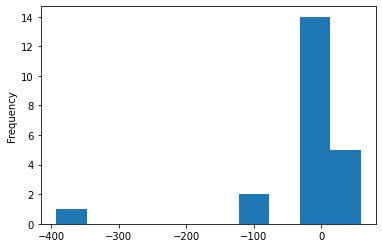

In [8]:
# Show histograms of errors

pred_df['forecast bias'].plot.hist(bins=10)

<AxesSubplot:ylabel='Frequency'>

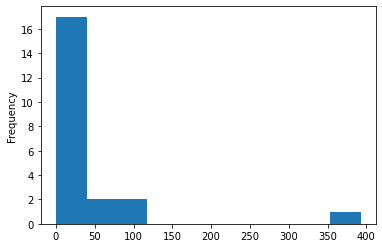

In [9]:
pred_df['rmse'].plot.hist(bins=10)

In [10]:
pred_df.describe()

,predicted,real,forecast bias,rmse
count,22.000000,22.000000,22.000000,22.000000
mean,155.045455,133.413636,-21.631818,40.895455
std,93.122795,10.785674,90.821155,83.586018
min,60.000000,118.000000,-392.500000,0.300000
25%,125.000000,124.475000,-15.175000,5.875000
50%,135.000000,131.500000,-0.150000,14.350000
75%,148.750000,141.675000,10.750000,31.250000
max,539.000000,154.300000,58.000000,392.500000


### Clarification:

Analysis of **Forecast Bias** and **Root Mean Squared Error** - their distribution and basic properties - could be a very useful tool to analyze model performance. However, take in mind that table above is a single test case (realization) and can be very misleading. Good idea is to repeat test dozens of times with a different training/test set division each time. After this we average results from multiple tests and we get an insight how our model behaves.

##### NOTE:

Those results are not decisive. Our sample is very small and output could be related to very unfortunate sampling over areas. The good idea is to repeat experiment multiple times with other samples and average results to find out how well model is performing.

---